In [ ]:
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv("data/train.csv", index_col = "Id")
test_data = pd.read_csv("data/test.csv", index_col = "Id")

Так как метрика в задаче — RMSE от логарифма цены, сразу заменим цену на ее логарифм, и будем оптимизировать RMSE.

In [4]:
train_data["SalePrice"] = train_data["SalePrice"].apply(np.log)

In [5]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

X = train_data.drop(columns = "SalePrice")
y = train_data["SalePrice"]

X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Препроцессинг
__common_transform — заменяет текстовые обозначения для качества на оценки от 1 до 5, чтобы модель понимала, что на этом признаке есть порядок. 

Далее выделяем категориальные и числовые признаки, и группируем категориальные признаки, частота которых меньше 2%.

Пропуски в категориальных признаках заменяяем на "None" — это будет отдельная категория.

In [6]:
class Preprocessor():
    def __init__(self):
        self.dict = {}
        self.categorical_cols = []
        self.numeric_cols = []

    def __common_transform(self, data):
        qual = {
            "Po": 1,
            "Fa": 2,
            "TA": 3,
            "Gd": 4,
            "Ex": 5
        }
        data["ExterQual"] = data["ExterQual"].map(qual)
        data["ExterCond"] = data["ExterCond"].map(qual)
        data["BsmtQual"] = data["BsmtQual"].map(qual)
        data["BsmtCond"] = data["BsmtCond"].map(qual)
        data["HeatingQC"] = data["HeatingQC"].map(qual)
        data["KitchenQual"] = data["KitchenQual"].map(qual)
        data["FireplaceQu"] = data["FireplaceQu"].map(qual)
        data["GarageQual"] = data["GarageQual"].map(qual)
        data["GarageCond"] = data["GarageCond"].map(qual)

    def fit_transform(self, data):
        self.__common_transform(data)
        threshold = 0.02 * len(data)
        self.categorical_cols = data.select_dtypes(include = ["object"]).columns.to_list()
        self.categorical_cols.append("MSSubClass")
        self.numeric_cols = data.select_dtypes(include = ["number"]).columns.to_list()
        self.numeric_cols.remove("MSSubClass")
        
        for col in self.categorical_cols:
            counts = data[col].value_counts()
            rare = counts[counts < threshold].index.to_list()
            self.dict[col] = rare
            data[col] = data[col].replace(self.dict[col], "Other")
        data[self.categorical_cols] = data[self.categorical_cols].fillna("None")
        

    def transform(self, data):
        self.__common_transform(data)
        data[self.categorical_cols] = data[self.categorical_cols].fillna("None")
        for col in self.categorical_cols:
            data[col] = data[col].replace(self.dict[col], "Other")   

        

In [7]:
prep = Preprocessor()
prep.fit_transform(X_train)
prep.transform(X_val)
prep.transform(X_test)

# Обучаем модель
Я пробовала разные learning_rate, depth, l2_leaf_reg, но скор на валидации был примерно одинаковым

In [8]:
from sklearn.metrics import mean_squared_error
model = CatBoostRegressor(
    iterations = 500,
    learning_rate = 0.1,
    depth = 4,
    l2_leaf_reg = 5,
    loss_function = "RMSE",
    eval_metric = "RMSE",
    cat_features = prep.categorical_cols,
    random_seed = 42
)

model.fit(X_train, y_train, eval_set = (X_val, y_val), early_stopping_rounds = 50, use_best_model = True, verbose = 0)
print("Лучшая итерация:", model.get_best_iteration())
y_pred = model.predict(X_val)
print("Score на валидационном наборе: ", np.sqrt(mean_squared_error(y_pred, y_val)))

Лучшая итерация: 358
Score на валидационном наборе:  0.1300563611441207


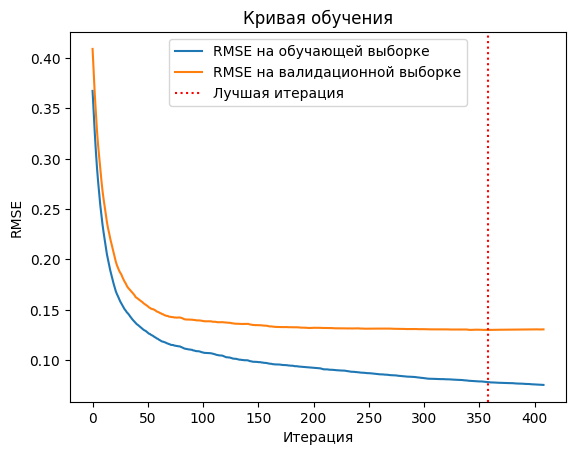

In [45]:
import matplotlib.pyplot as plt
evals = model.get_evals_result()
plt.plot(evals["learn"]["RMSE"], label = "RMSE на обучающей выборке")
plt.plot(evals["validation"]["RMSE"], label = "RMSE на валидационной выборке")
plt.xlabel("Итерация")
plt.ylabel("RMSE")
plt.title("Кривая обучения")
plt.axvline(model.get_best_iteration(), linestyle = ":", label = "Лучшая итерация", c = "red")
plt.legend()

# Делаем submit на Kaggle

In [10]:
y_preds_final = model.predict(X_test)
submission = pd.DataFrame({
    "Id": X_test.index.to_list(),
    "SalePrice": np.exp(y_preds_final)
})

In [11]:
submission.to_csv("submission.csv", index = False)

# Удаление признаков с низкой важностью
Попробуем улучшить качество с помощью удаления неважных признаков.

Я отбираю признаки, которые имеют важность меньше 2% от максимальной важности.

In [12]:
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

In [13]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
})
max_importance = fi_df["Importance"].max()
threshold = max_importance * 0.02

In [14]:
low_imp_f = fi_df[fi_df["Importance"] < threshold]["Feature"].to_list()
low_imp_f

['MSSubClass',
 'LotFrontage',
 'Street',
 'Alley',
 'LotShape',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterCond',
 'Foundation',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'Heating',
 'LowQualFinSF',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'KitchenAbvGr',
 'PavedDrive',
 'WoodDeckSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType']

Будем удалять эти признаки по одному и смотреть на скор на валидации.

In [15]:
models_drop = []
scores = []
for f in low_imp_f:
    X_train_drop = X_train.drop(columns = f)
    X_val_drop = X_val.drop(columns = f)
    cat_features = prep.categorical_cols.copy()
    if f in cat_features:
        cat_features.remove(f)
    model_drop = CatBoostRegressor(
        iterations = 500,
        learning_rate = 0.1,
        depth = 4,
        l2_leaf_reg = 5,
        loss_function = "RMSE",
        eval_metric = "RMSE",
        cat_features = cat_features,
        random_seed = 42,
        verbose = 0
    )
    model_drop.fit(X_train_drop, y_train, eval_set = (X_val_drop, y_val), early_stopping_rounds = 50, use_best_model = True)
    models_drop.append(model_drop)
    y_pred = model_drop.predict(X_val_drop)
    scores.append(np.sqrt(mean_squared_error(y_pred, y_val)))
    print(f"{f}: {scores[-1]}")
    
    

MSSubClass: 0.13112561225254374
LotFrontage: 0.13690760773177998
Street: 0.13079536835781466
Alley: 0.13233027996356045
LotShape: 0.1330009018578437
Utilities: 0.13300933707415974
LotConfig: 0.13501313014287677
LandSlope: 0.13312827826412862
Condition2: 0.13079536835781466
BldgType: 0.1337260226793487
HouseStyle: 0.13391258268025885
RoofStyle: 0.13295284780810201
RoofMatl: 0.13104940430446782
Exterior1st: 0.13506131040324967
Exterior2nd: 0.13313448075614123
MasVnrType: 0.1328125874987869
MasVnrArea: 0.12909356485886422
ExterCond: 0.13251502911923652
Foundation: 0.13243565007975072
BsmtFinType1: 0.1323222736583374
BsmtFinType2: 0.13284494234137537
BsmtFinSF2: 0.1294087683551894
Heating: 0.1294962093941361
LowQualFinSF: 0.133820054412138
BsmtHalfBath: 0.13257392159105147
FullBath: 0.13099642240068943
HalfBath: 0.13346532067044778
KitchenAbvGr: 0.13175923401952122
PavedDrive: 0.13362629394199377
WoodDeckSF: 0.1305690687227703
EnclosedPorch: 0.13078603649681092
3SsnPorch: 0.132298748148959

# Делаем submit
Скор улучшился при удалении признаков: SaleType, MasVnrArea, BsmtFinSF2, Heating. Попробуем каждый удалить и отправить на Kaggle

In [16]:
y_preds_final_st = models_drop[low_imp_f.index("SaleType")].predict(X_test.drop(columns = "SaleType"))
submission_st = pd.DataFrame({
    "Id": X_test.index.to_list(),
    "SalePrice": np.exp(y_preds_final_st)
})

In [17]:
submission_st.to_csv("submission_st.csv", index = False)

In [18]:
y_preds_final_mva = models_drop[low_imp_f.index("MasVnrArea")].predict(X_test.drop(columns = "MasVnrArea"))
submission_mva = pd.DataFrame({
    "Id": X_test.index.to_list(),
    "SalePrice": np.exp(y_preds_final_mva)
})

In [19]:
submission_mva.to_csv("submission_mva.csv", index = False)

In [20]:
y_preds_final_bfs = models_drop[low_imp_f.index("BsmtFinSF2")].predict(X_test.drop(columns = "BsmtFinSF2"))
submission_bfs = pd.DataFrame({
    "Id": X_test.index.to_list(),
    "SalePrice": np.exp(y_preds_final_bfs)
})

In [21]:
submission_bfs.to_csv("submission_bfs.csv", index = False)

In [22]:
y_preds_final_h = models_drop[low_imp_f.index("Heating")].predict(X_test.drop(columns = "Heating"))
submission_h = pd.DataFrame({
    "Id": X_test.index.to_list(),
    "SalePrice": np.exp(y_preds_final_h)
})

In [23]:
submission_h.to_csv("submission_h.csv", index = False)

# Лучший submit
Лучший скор на тесте получился у модели с удаленным столбцом BsmtFinSF2:

0.12671